### Importing and get rawdata [rawdata]

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import h5py
import sys
# from qnl_analysis.lib.toolbox import toolbox as tb
# import qnl_analysis.analysis_utils as au

#: get data from h5
# f = h5py.File('163223_Trajectories.hdf5','r')
# # to view the insides of the h5, use print f.keys()
# rawdata = f['data']['Dependent0'][()] #this turns the h5data into a numpy file
# print 'Shape of raw data: ', rawdata.shape
# f.close()


In [3]:
# #: get data from Emu 
# some trajectory files
""" '163223_Trajectories.hdf5', \
    '//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170214/115616_Trajectories_0_/115616_Trajectories_0_.hdf5', \
    '//EMU/Emu/Projects/2016-3QubitCEQ/Data-Raw/20170214/115703_Trajectories_1_/115703_Trajectories_1_.hdf5', """

for filename in ['163223_Trajectories.hdf5']:
    f = h5py.File(filename,'r')
    rawdata = f['data']['Dependent0'][()][:, :, 0:4, :] #this turns the h5data into a numpy file
    print filename
    print 'Shape of raw data: ', rawdata.shape
    f.close()

163223_Trajectories.hdf5
Shape of raw data:  (2L, 5000L, 4L, 5000L)


# 1. Preparing the rawdata into a proper format to train our classifier

### Get traj_demod and traj_av_demod from rawdata; important variables: [traj_demod, traj_av_demod]

In [4]:

#: params for the rawdata 
numTrajs = rawdata.shape[1] #5000 #num trajectories per label
duration = rawdata.shape[3] #5000 #time duration of entire track, in nanoseconds


#: params for demod
demod_freq =   0.047000000 #47 MHz = 0.047GHz
clock_freq = 1.000000000 # 1000MHz =1 GHz
rotation = 0
# demod_decay = None  #obsolete
start_window = 0 #units of time
end_window = duration #is this the correct end_window?



#: demod code
times = np.arange( int(start_window*clock_freq), int(end_window*clock_freq) ) * float(demod_freq/(clock_freq)) #unitless
demod_exp = np.exp(1j*(2*np.pi*times-rotation))
# if demod_decay is not None:   #obsolete
#     demod_exp *= np.exp(-1*times/(demod_decay*demod_freq))
demod_exp_I = np.array(np.real(demod_exp), dtype='float32')
demod_exp_Q = np.array(np.imag(demod_exp), dtype='float32')


#: traj_demod and traj_av_demod
traj_demod=np.zeros((2, 4, numTrajs, duration)) # indices are: iqIndex, labelIndex, trajIndex, timeIndex  ;  value is the i or q quadrature value
traj_av_demod=np.zeros((2, 4, duration)) # averages over the trajs; indices: iqIndex, labelIndex, timeIndex


for labelIndex in np.arange(4):
    for trajIndex in np.arange(numTrajs):
        traj_demod[0,labelIndex,trajIndex]=( (rawdata[0, trajIndex, labelIndex, :] - rawdata[0, trajIndex, labelIndex, :].mean())*demod_exp_I    -    (rawdata[1, trajIndex, labelIndex, :] - rawdata[1, trajIndex, labelIndex, :].mean())*demod_exp_Q)
        traj_demod[1,labelIndex,trajIndex]=( (rawdata[0, trajIndex, labelIndex, :] - rawdata[0, trajIndex, labelIndex, :].mean())*demod_exp_Q    +    (rawdata[1, trajIndex, labelIndex, :] - rawdata[1, trajIndex, labelIndex, :].mean())*demod_exp_I)
    traj_av_demod[0, labelIndex] = traj_demod[0, labelIndex,:,:].mean(0)
    traj_av_demod[1, labelIndex] = traj_demod[1, labelIndex,:,:].mean(0)
    

### Get the slotWeights by difference in avg trajs (Perform "slot integration", or "slotting",  on the traj_av_demod); [slotWeights_repeated]

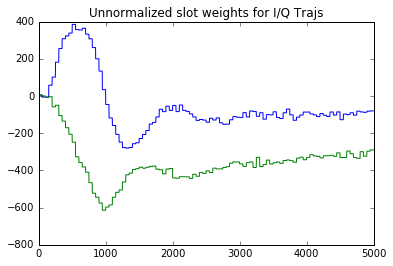

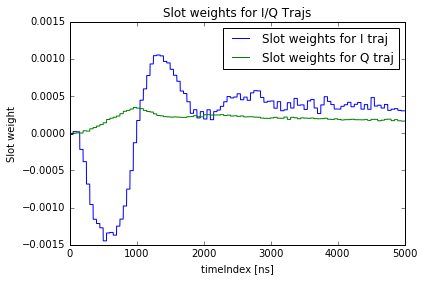

In [5]:
slotsize=50



traj_av_demod_slotted = np.zeros((2, 4, duration/slotsize)) # indices: iqIndex, labelIndex, slotIndex

for labelIndex in np.arange(4):
    for j in np.arange(duration/slotsize): #j is slotIndex
        traj_av_demod_slotted[0,labelIndex, j]=traj_av_demod[0,labelIndex,j*slotsize:j*slotsize+slotsize].mean()
        traj_av_demod_slotted[1,labelIndex, j]=traj_av_demod[1,labelIndex,j*slotsize:j*slotsize+slotsize].mean()
        

traj_av_demod_slotted_notgg = traj_av_demod_slotted[:, 1:4, :].mean(axis=1) # average over the eg,ge,ee  trajectories
traj_av_demod_slotted_gg = traj_av_demod_slotted[:, 0, :]

#: create slotweights and then normalize them
slotWeights = traj_av_demod_slotted_gg - traj_av_demod_slotted_notgg
# slotWeights[0, :] = slotWeights[0, :] / slotWeights.sum(axis=1)[0] #indices for slotWeights: iqIndex, slotIndex
# slotWeights[1, :] = slotWeights[1, :] / slotWeights.sum(axis=1)[1]
slotWeights_repeated = np.repeat(slotWeights, slotsize, axis=1) # repeats elements of slotWeights such that the indices are now (iqIndex, timeIndex)

plt.figure()
plt.plot(slotWeights_repeated[0,:])
plt.plot(slotWeights_repeated[1,:])
plt.title('Unnormalized slot weights for I/Q Trajs')

slotWeights_repeated[0, :] = slotWeights_repeated[0, :] / slotWeights_repeated.sum(axis=1)[0]
slotWeights_repeated[1, :] = slotWeights_repeated[1, :] / slotWeights_repeated.sum(axis=1)[1]
        
#: plot the slot weights
plt.figure()
plt.plot(slotWeights_repeated[0,:])
plt.plot(slotWeights_repeated[1,:])
plt.title('Slot weights for I/Q Trajs')
plt.legend(['Slot weights for I traj', 'Slot weights for Q traj'])
plt.xlabel('timeIndex [ns]')
plt.ylabel('Slot weight')

### Get integrated data (weighted with slot weights); [integratedTraj_slotWeights, integratedTraj_naive]

In [6]:
#: getting slot weight integrated data for hists
integratedTraj_slotWeights = np.zeros([2, numTrajs, 4]) #indices: iqIndex, trajindex, labelindex  ;  value: mean quadrature value, weighted with slot weights
integratedTraj_naive = np.zeros([2, numTrajs, 4]) #value: mean i/q quadrature (no weights)

for labelIndex in np.arange(0, 4): 
    for trajIndex in np.arange(0, numTrajs):
        integratedTraj_slotWeights[0, trajIndex, labelIndex] = (traj_demod[0, labelIndex, trajIndex, :] * slotWeights_repeated[0]).mean(axis=0)
        integratedTraj_slotWeights[1, trajIndex, labelIndex] = (traj_demod[1, labelIndex, trajIndex, :] * slotWeights_repeated[1]).mean(axis=0)
        
        integratedTraj_naive[0, trajIndex, labelIndex] = (traj_demod[0, labelIndex, trajIndex, :] * (np.ones(duration) / duration)).mean(axis=0)
        integratedTraj_naive[1, trajIndex, labelIndex] = (traj_demod[1, labelIndex, trajIndex, :] * (np.ones(duration) / duration)).mean(axis=0)
        


# 2. Now, use training set to train the clf

### Plot 2D histograms; [hist2d_slotWeightsInt_gg, hist2d_slotWeightsInt_exc, hist2d_naiveInt_gg, hist2d_naiveInt_exc]

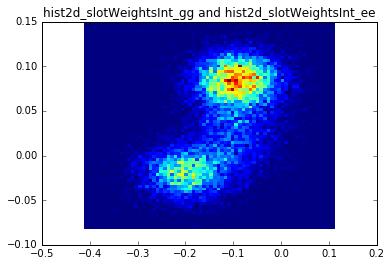

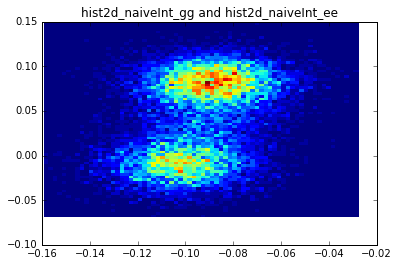

In [7]:
#: params
numBins = 70
trainFraction = 4./5 #fraction of numTrajs to use as training set


startTest = int(numTrajs*trainFraction) # start index for test data

#: need these to plug into histograms
slotWeightsInt_exc_I = np.append(integratedTraj_slotWeights[0, 0:startTest, 3], [integratedTraj_slotWeights[0, 0:startTest, 1], integratedTraj_slotWeights[0, 0:startTest, 2]])
slotWeightsInt_exc_Q = np.append(integratedTraj_slotWeights[1, 0:startTest, 3], [integratedTraj_slotWeights[1, 0:startTest, 1], integratedTraj_slotWeights[1, 0:startTest, 2]])
naiveInt_exc_I = np.append(integratedTraj_naive[0, 0:startTest, 3], [integratedTraj_naive[0, 0:startTest, 1], integratedTraj_naive[0, 0:startTest, 2]])
naiveInt_exc_Q = np.append(integratedTraj_naive[1, 0:startTest, 3], [integratedTraj_naive[1, 0:startTest, 1], integratedTraj_naive[1, 0:startTest, 2]])




#:create histograms
minIntegratedTraj_I = np.min(integratedTraj_slotWeights[0, 0:startTest, :])
maxIntegratedTraj_I = np.max(integratedTraj_slotWeights[0, 0:startTest, :])
minIntegratedTraj_Q = np.min(integratedTraj_slotWeights[1, 0:startTest, :])
maxIntegratedTraj_Q = np.max(integratedTraj_slotWeights[1, 0:startTest, :])
hist2d_slotWeightsInt_gg, binEdges_slotWeightsInt_I, binEdges_slotWeightsInt_Q = np.histogram2d(integratedTraj_slotWeights[0, 0:startTest, 0], integratedTraj_slotWeights[1, 0:startTest, 0], \
                                                                                                bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
# hist2d_slotWeightsInt_ee, _, _ = np.histogram2d(integratedTraj_slotWeights[0, 0:startTest, 3], integratedTraj_slotWeights[1, 0:startTest, 3], bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
hist2d_slotWeightsInt_exc, _, _ = np.histogram2d(slotWeightsInt_exc_I, slotWeightsInt_exc_Q, \
                                                 bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])

minIntegratedTraj_I = np.min(integratedTraj_naive[0, 0:startTest, :])
maxIntegratedTraj_I = np.max(integratedTraj_naive[0, 0:startTest, :])
minIntegratedTraj_Q = np.min(integratedTraj_naive[1, 0:startTest, :])
maxIntegratedTraj_Q = np.max(integratedTraj_naive[1, 0:startTest, :])
hist2d_naiveInt_gg, binEdges_naiveInt_I, binEdges_naiveInt_Q = np.histogram2d(integratedTraj_naive[0, 0:startTest, 0], integratedTraj_naive[1, 0:startTest, 0], \
                                                                              bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
# hist2d_naiveInt_ee, _, _ = np.histogram2d(integratedTraj_naive[0, 0:startTest, 3], integratedTraj_naive[1, 0:startTest, 3], bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
hist2d_naiveInt_exc, _, _ = np.histogram2d(naiveInt_exc_I, naiveInt_exc_Q, \
                                                 bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])


#: plot slotweightsInt hist2d
coordsX, coordsY = np.meshgrid(binEdges_slotWeightsInt_I, binEdges_slotWeightsInt_Q)
# plt.pcolormesh(coordsX, coordsY, hist2d_slotWeightsInt_gg + hist2d_slotWeightsInt_ee)
# plt.pcolormesh(coordsX, coordsY, hist2d_slotWeightsInt_gg.T + hist2d_slotWeightsInt_ee.T)
plt.pcolormesh(coordsX, coordsY, hist2d_slotWeightsInt_gg.T + hist2d_slotWeightsInt_exc.T)
plt.title('hist2d_slotWeightsInt_gg and hist2d_slotWeightsInt_exc')


#: plot naiveInt hist2d
plt.figure()
coordsX, coordsY = np.meshgrid(binEdges_naiveInt_I, binEdges_naiveInt_Q)
# plt.pcolormesh(coordsX, coordsY, hist2d_naiveInt_gg.T + hist2d_naiveInt_ee.T)
plt.pcolormesh(coordsX, coordsY, hist2d_naiveInt_gg.T + hist2d_naiveInt_exc.T)
plt.title('hist2d_naiveInt_gg and hist2d_naiveInt_exc')



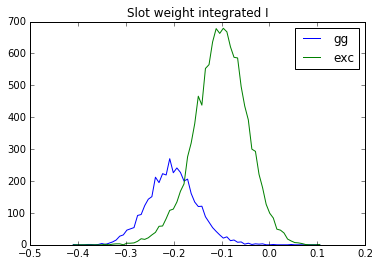

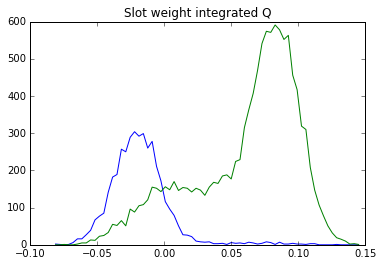

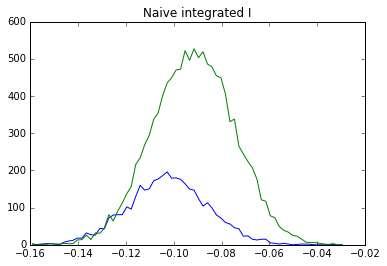

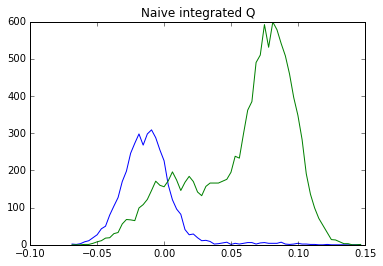

In [19]:
plt.plot(binEdges_slotWeightsInt_I[:-1], hist2d_slotWeightsInt_gg.sum(1))
# plt.plot(binEdges_slotWeightsInt_I[:-1], hist2d_slotWeightsInt_ee.sum(1))
plt.plot(binEdges_slotWeightsInt_I[:-1], hist2d_slotWeightsInt_exc.sum(1))
plt.legend(['gg', 'exc'])
plt.title('Slot weight integrated I')

plt.figure()
plt.plot(binEdges_slotWeightsInt_Q[:-1], hist2d_slotWeightsInt_gg.sum(0))
# plt.plot(binEdges_slotWeightsInt_Q[:-1], hist2d_slotWeightsInt_ee.sum(0))
plt.plot(binEdges_slotWeightsInt_Q[:-1], hist2d_slotWeightsInt_exc.sum(0))
plt.title('Slot weight integrated Q')

plt.figure()
plt.plot(binEdges_naiveInt_I[:-1], hist2d_naiveInt_gg.sum(1))
# plt.plot(binEdges_naiveInt_I[:-1], hist2d_naiveInt_ee.sum(1))
plt.plot(binEdges_naiveInt_I[:-1], hist2d_naiveInt_exc.sum(1))
plt.title('Naive integrated I')

plt.figure()
plt.plot(binEdges_naiveInt_Q[:-1], hist2d_naiveInt_gg.sum(0))
# plt.plot(binEdges_naiveInt_Q[:-1], hist2d_naiveInt_ee.sum(0))
plt.plot(binEdges_naiveInt_Q[:-1], hist2d_naiveInt_exc.sum(0))
plt.title('Naive integrated Q')

### Now, find theta (angle needed to rotate), then rotate the data sets; [integratedTraj_slotWeights_rotated, integratedTraj_naive_rotated]

In [9]:
#: theta is the angle that the vector (ee_mean_position - gg_mean_position) makes with pos x direction.
# theta_SWInt = np.arctan2(integratedTraj_slotWeights[0, 0:startTest, 3].mean() - integratedTraj_slotWeights[0, 0:startTest, 0].mean(), integratedTraj_slotWeights[1, 0:startTest, 3].mean() - integratedTraj_slotWeights[1, 0:startTest, 0].mean())
theta_SWInt = np.arctan2(slotWeightsInt_exc_I.mean() - integratedTraj_slotWeights[0, 0:startTest, 0].mean(), slotWeightsInt_exc_Q.mean() - integratedTraj_slotWeights[1, 0:startTest, 0].mean())

# theta_naiveInt = np.arctan2(integratedTraj_naive[0, 0:startTest, 3].mean() - integratedTraj_naive[0, 0:startTest, 0].mean(), integratedTraj_naive[1, 0:startTest, 3].mean() - integratedTraj_naive[1, 0:startTest, 0].mean())
theta_naiveInt = np.arctan2(naiveInt_exc_I.mean() - integratedTraj_naive[0, 0:startTest, 0].mean(), naiveInt_exc_Q.mean() - integratedTraj_naive[1, 0:startTest, 0].mean())

print 'theta_SWInt is: ', theta_SWInt, '; i.e.: ', theta_SWInt*180/np.pi, 'degrees.'
print 'theta_naiveInt is: ', theta_naiveInt, '; i.e.: ', theta_naiveInt*180/np.pi, 'degrees.'


theta_SWInt is:  0.903529190173 ; i.e.:  51.7684092638 degrees.
theta_naiveInt is:  0.149373851585 ; i.e.:  8.55849126541 degrees.


In [10]:
integratedTraj_slotWeights_rotated = np.zeros([2, numTrajs, 4]) # rotate all data (insluding test set)
integratedTraj_naive_rotated = np.zeros([2, numTrajs, 4])

#: rotate SWInt blobs by -theta degrees (rotating by x degrees means rotating CCW by x)
mag = np.sqrt(integratedTraj_slotWeights[0,:,:]**2 + integratedTraj_slotWeights[1,:,:]**2) #the the magnitude (length) of each IQ vector in I-Q space
phi = np.arctan2(integratedTraj_slotWeights[0,:,:], integratedTraj_slotWeights[1,:,:])
integratedTraj_slotWeights_rotated[0,:,:] = mag * np.cos(phi - theta_SWInt)
integratedTraj_slotWeights_rotated[1,:,:] = mag * np.sin(phi - theta_SWInt)

#: rotate naiveInt blobs
mag = np.sqrt(integratedTraj_naive[0,:,:]**2 + integratedTraj_naive[1,:,:]**2) #the the magnitude (length) of each IQ vector in I-Q space
phi = np.arctan2(integratedTraj_naive[0,:,:], integratedTraj_naive[1,:,:])
integratedTraj_naive_rotated[0,:,:] = mag * np.cos(phi - theta_naiveInt)
integratedTraj_naive_rotated[1,:,:] = mag * np.sin(phi - theta_naiveInt)


### Plot the 2d histograms; [hist2d_slotWeightsInt_gg_rotated, hist2d_slotWeightsInt_exc_rotated, hist2d_naiveInt_gg_rotated, hist2d_naiveInt_exc_rotated]

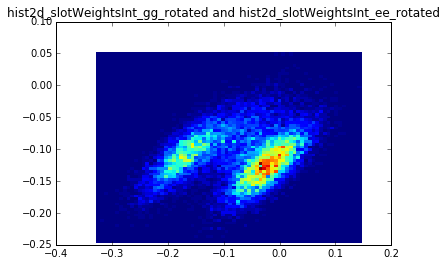

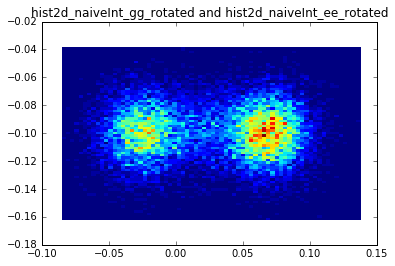

In [16]:
#: need these to plug into histograms
slotWeightsInt_exc_I_rotated = np.append(integratedTraj_slotWeights_rotated[0, 0:startTest, 3], [integratedTraj_slotWeights_rotated[0, 0:startTest, 1], integratedTraj_slotWeights_rotated[0, 0:startTest, 2]])
slotWeightsInt_exc_Q_rotated = np.append(integratedTraj_slotWeights_rotated[1, 0:startTest, 3], [integratedTraj_slotWeights_rotated[1, 0:startTest, 1], integratedTraj_slotWeights_rotated[1, 0:startTest, 2]])
naiveInt_exc_I_rotated = np.append(integratedTraj_naive_rotated[0, 0:startTest, 3], [integratedTraj_naive_rotated[0, 0:startTest, 1], integratedTraj_naive_rotated[0, 0:startTest, 2]])
naiveInt_exc_Q_rotated = np.append(integratedTraj_naive_rotated[1, 0:startTest, 3], [integratedTraj_naive_rotated[1, 0:startTest, 1], integratedTraj_naive_rotated[1, 0:startTest, 2]])


minIntegratedTraj_I = np.min(integratedTraj_slotWeights_rotated[0, 0:startTest, :])
maxIntegratedTraj_I = np.max(integratedTraj_slotWeights_rotated[0, 0:startTest, :])
minIntegratedTraj_Q = np.min(integratedTraj_slotWeights_rotated[1, 0:startTest, :])
maxIntegratedTraj_Q = np.max(integratedTraj_slotWeights_rotated[1, 0:startTest, :])
hist2d_slotWeightsInt_gg_rotated, binEdges_slotWeightsInt_I_rotated, binEdges_slotWeightsInt_Q_rotated = np.histogram2d(integratedTraj_slotWeights_rotated[0,0:startTest,0], integratedTraj_slotWeights_rotated[1,0:startTest,0], bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
# hist2d_slotWeightsInt_ee_rotated, _, _ = np.histogram2d(integratedTraj_slotWeights_rotated[0,0:startTest,3], integratedTraj_slotWeights_rotated[1,0:startTest,3], bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
hist2d_slotWeightsInt_exc_rotated, _, _ = np.histogram2d(slotWeightsInt_exc_I_rotated, slotWeightsInt_exc_Q_rotated, bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])


minIntegratedTraj_I = np.min(integratedTraj_naive_rotated[0, 0:startTest, :])
maxIntegratedTraj_I = np.max(integratedTraj_naive_rotated[0, 0:startTest, :])
minIntegratedTraj_Q = np.min(integratedTraj_naive_rotated[1, 0:startTest, :])
maxIntegratedTraj_Q = np.max(integratedTraj_naive_rotated[1, 0:startTest, :])
hist2d_naiveInt_gg_rotated, binEdges_naiveInt_I_rotated, binEdges_naiveInt_Q_rotated = np.histogram2d(integratedTraj_naive_rotated[0,0:startTest,0], integratedTraj_naive_rotated[1,0:startTest,0], bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
# hist2d_naiveInt_ee_rotated, _, _ = np.histogram2d(integratedTraj_naive_rotated[0,0:startTest,3], integratedTraj_naive_rotated[1,0:startTest,3], bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])
hist2d_naiveInt_exc_rotated, _, _ = np.histogram2d(naiveInt_exc_I_rotated, naiveInt_exc_Q_rotated, bins=numBins, range=[[minIntegratedTraj_I, maxIntegratedTraj_I], [minIntegratedTraj_Q, maxIntegratedTraj_Q]])


#: plot slotweightsInt hist2d
coordsX, coordsY = np.meshgrid(binEdges_slotWeightsInt_I_rotated, binEdges_slotWeightsInt_Q_rotated)
# plt.pcolormesh(coordsX, coordsY, hist2d_slotWeightsInt_gg + hist2d_slotWeightsInt_ee)
plt.pcolormesh(coordsX, coordsY, hist2d_slotWeightsInt_gg_rotated.T + hist2d_slotWeightsInt_exc_rotated.T)
plt.title('hist2d_slotWeightsInt_gg_rotated and hist2d_slotWeightsInt_ee_rotated')


#: plot naiveInt hist2d
plt.figure()
coordsX, coordsY = np.meshgrid(binEdges_naiveInt_I_rotated, binEdges_naiveInt_Q_rotated)
plt.pcolormesh(coordsX, coordsY, hist2d_naiveInt_gg_rotated.T + hist2d_naiveInt_exc_rotated.T) #need to transpose to display properly
plt.title('hist2d_naiveInt_gg_rotated and hist2d_naiveInt_ee_rotated')

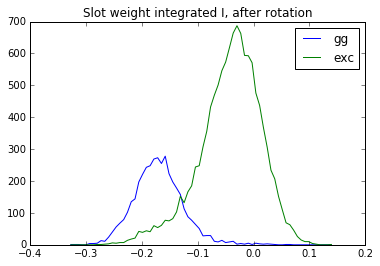

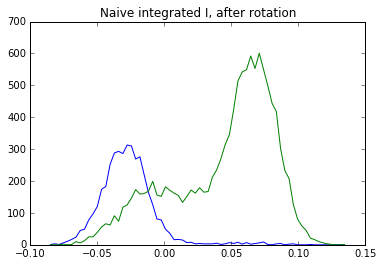

In [22]:
# print hist2d_naiveInt_gg_rotated.sum(1)


plt.plot(binEdges_slotWeightsInt_I_rotated[:-1], hist2d_slotWeightsInt_gg_rotated.sum(1))
plt.plot(binEdges_slotWeightsInt_I_rotated[:-1], hist2d_slotWeightsInt_exc_rotated.sum(1))
plt.legend(['gg', 'exc'])
plt.title('Slot weight integrated I, after rotation')

plt.figure()
plt.plot(binEdges_naiveInt_I_rotated[:-1], hist2d_naiveInt_gg_rotated.sum(1))
plt.plot(binEdges_naiveInt_I_rotated[:-1], hist2d_naiveInt_exc_rotated.sum(1))
plt.title('Naive integrated I, after rotation')

### Find decision boundary on the training data. This fidelity only works if gg gaussian is to the left of the ee gaussian; [decbound_ggexc_I_naive, fid_ggexc_I_slotWeights]

In [36]:

numTrain = numTrajs * trainFraction # number of training data points

# #: fid_ggee is F_{gg-ee}
# fid_ggee_I_naive=[] # F_{gg-ee} for I quadrature, using naive integration
# fid_ggee_I_slotWeights=[] # F_{gg-ee} for I quadrature, using naive integration

# for k in np.arange(numBins+1): 
#     fid_ggee_I_naive.append((hist2d_naiveInt_gg_rotated.sum(1)[0:k] - hist2d_naiveInt_ee_rotated.sum(1)[0:k]).sum())
#     fid_ggee_I_slotWeights.append((hist2d_slotWeightsInt_gg_rotated.sum(1)[0:k] - hist2d_slotWeightsInt_ee_rotated.sum(1)[0:k]).sum())
# decbound_ggee_I_naive = binEdges_naiveInt_I_rotated[np.argmax(fid_ggee_I_naive)] # decision boundary
# fid_ggee_I_naive = (1 + np.max(fid_ggee_I_naive)/numTrain) / 2
# decbound_ggee_I_slotWeights = binEdges_slotWeightsInt_I_rotated[np.argmax(fid_ggee_I_slotWeights)]
# fid_ggee_I_slotWeights = (1 + np.max(fid_ggee_I_slotWeights)/numTrain) / 2


# print 'fid_ggee_I_naive: ', fid_ggee_I_naive
# print 'decbound_ggee_I_naive: ', decbound_ggee_I_naive
# print 'fid_ggee_I_slotWeights: ', fid_ggee_I_slotWeights
# print 'decbound_ggee_I_slotWeights: ', decbound_ggee_I_slotWeights




#: "full" fidelity is F_{gg-exc}, i.e. fid_ggexc
temp_I_naive=[] # temp variable to help calculate the fidelity 
temp_I_slotWeights=[] 

num_gg = hist2d_naiveInt_gg_rotated.sum(1).sum() #number of gg points. should be equal to numTrain
num_exc = hist2d_naiveInt_gg_rotated.sum(1).sum() #number of exc points. should be equal to 3 * numTrain

for k in np.arange(numBins+1): 
    temp_I_naive.append((hist2d_naiveInt_gg_rotated.sum(1)[0:k]/num_gg - hist2d_naiveInt_exc_rotated.sum(1)[0:k]/num_exc).sum())
    temp_I_slotWeights.append((hist2d_slotWeightsInt_gg_rotated.sum(1)[0:k]/num_gg - hist2d_slotWeightsInt_exc_rotated.sum(1)[0:k]/num_exc).sum())
decbound_ggexc_I_naive = binEdges_naiveInt_I_rotated[np.argmax(temp_I_naive)] # decision boundary
fid_ggexc_I_naive = (1 + np.max(temp_I_naive)) / 2 #full fid for I quadrature, using naive integration
decbound_ggexc_I_slotWeights = binEdges_slotWeightsInt_I_rotated[np.argmax(temp_I_slotWeights)]
fid_ggexc_I_slotWeights = (1 + np.max(temp_I_slotWeights)) / 2  # full fid for I quadrature, using naive integration


print 'fid_ggexc_I_naive: ', fid_ggexc_I_naive
print 'decbound_ggexc_I_naive: ', decbound_ggexc_I_naive
print 'fid_ggexc_I_slotWeights: ', fid_ggexc_I_slotWeights
print 'decbound_ggexc_I_slotWeights: ', decbound_ggexc_I_slotWeights



fid_ggexc_I_naive:  0.745375
decbound_ggexc_I_naive:  -0.0117908794251
fid_ggexc_I_slotWeights:  0.814125
decbound_ggexc_I_slotWeights:  -0.124400369978


In [37]:
def clf_naiveInt_predict(naiveInt_I):
    if naiveInt_I <= decbound_ggee_I_naive:
        return 0 #gg
    else:
        return 1 #ee

def clf_slotWeightsInt_predict(slotWeightsInt_I):
    if slotWeightsInt_I <= decbound_ggee_I_slotWeights:
        return 0 #gg
    else:
        return 1 #ee

# 3. Calculate fidelity on the test set

In [39]:
num_0 = int(numTrajs*(1-trainFraction)) # number of gg's
num_1 = int(numTrajs*(1-trainFraction)) # number of excited states


# predicted_labels01 = np.zeros(integratedTraj_slotWeights_rotated[0,startTest: *4,])
p_0_1_naive = 0 # Prob(0|excited) for naiveInt method
p_1_0_naive = 0 # Prob(1|gg)
p_0_1_SW = 0 # Prob(0|excited) for slotWeights method
p_1_0_SW = 0 # Prob(1|gg)


for i in np.arange(int(numTrajs*(1-trainFraction))):
    if (clf_naiveInt_predict(integratedTraj_naive_rotated[0, startTest+i, 1]) == 0):
        p_0_1_naive = p_0_1_naive + 1
    if (clf_naiveInt_predict(integratedTraj_naive_rotated[0, startTest+i, 0]) == 1):
        p_1_0_naive = p_1_0_naive + 1
    
    if (clf_slotWeightsInt_predict(integratedTraj_slotWeights_rotated[0, startTest+i, 1]) == 0):
        p_0_1_SW = p_0_1_SW + 1
    if (clf_slotWeightsInt_predict(integratedTraj_slotWeights_rotated[0, startTest+i, 0]) == 1):
        p_1_0_SW = p_1_0_SW + 1
    

p_0_1_naive = 1.0 * p_0_1_naive / num_1
p_1_0_naive = 1.0 * p_1_0_naive / num_0

p_0_1_SW = 1.0 * p_0_1_SW / num_1
p_1_0_SW = 1.0 * p_1_0_SW / num_0

fid_naive = 1 - (p_0_1_naive + p_1_0_naive) / 2
fid_SW = 1 - (p_0_1_SW + p_1_0_SW) / 2
print 'fid_naive: ', fid_naive
print 'fid_SW: ', fid_SW


fid_naive:  0.837837837838
fid_SW:  0.871371371371


In [7]:
import sys
import pprint
pprint.pprint(sys.path)

['',
 'C:\\Anaconda2\\lib\\site-packages\\service_identity-16.0.0-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\twisted-16.4.1-py2.7-win-amd64.egg',
 'C:\\Anaconda2\\lib\\site-packages\\pyasn1_modules-0.0.8-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\attrs-16.2.0-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\zope.interface-4.3.2-py2.7-win-amd64.egg',
 'C:\\Anaconda2\\lib\\site-packages\\setuptools-23.0.0-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\lockfile-0.12.2-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\gitpython-2.0.8-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\dpath-1.4.0-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\gitdb-0.6.4-py2.7-win-amd64.egg',
 'C:\\Anaconda2\\lib\\site-packages\\smmap-0.9.0-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\qdarkstyle-2.2.1-py2.7.egg',
 'C:\\Anaconda2\\lib\\site-packages\\peakutils-1.0.3-py2.7.egg',
 'c:\\users\\qnl\\desktop\\qnl_ctrl',
 'C:\\Anaconda2\\lib\\site-packages\\pylabrad-0.96.5.dev5+ng61fa17d-py2.7.egg